## Data Sources 

Original Data Sources:
- Wise reviews: [https://www.trustpilot.com/review/wise.com](https://www.trustpilot.com/review/wise.com)
- PayPal reviews: [https://www.trustpilot.com/review/www.paypal.com](https://www.trustpilot.com/review/www.paypal.com)

Those two websites were scraped and the resulting reviews data stored in [this Google Drive folder](https://drive.google.com/drive/folders/16U3TSFpqKqPle5OLgdGZ5KHQK1UQ7n9n?usp=sharing)

In [6]:
import json, time
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import f1_score

import ast #to convert string into dictionary
from IPython.display import clear_output

from sklearn import svm
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("pastel")
sns.set(rc={'axes.facecolor':'#f5f5f5', 'figure.facecolor':'#f5f5f5'})

## Preprocessing - Loading and cleaning the data

In [7]:
class Sentiment:
    POSITIVE = 0
    NEGATIVE = 1
    NEUTRAL = 2

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: #Score of 4 or 5
            return Sentiment.POSITIVE

class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
        
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        negative = negative[:5000]
        positive_shrunk = positive[:len(negative)]
        self.reviews = negative + positive_shrunk


In [8]:
labels = {
    0: "Positive",
    1: "Negative",
    2: "Neutral"
}

In [9]:
# Loading data after downloading them from Google Drive - Please modify the paths accordingly.
wise = json.load(open("../Web Scraping and EDA/wise.json"))
print("Number of Wise Reviews: ", len(wise))

paypal = json.load(open("../Web Scraping and EDA/paypal.json"))
print("Number of PayPal Reviews: ", len(paypal))

Number of Wise Reviews:  79868
Number of PayPal Reviews:  19240


In [10]:
wise[0] # A sample review made for Wise

{'platform': 'Wise',
 'id': '60b8b3f2f9f4870b70161798',
 'stars': 5,
 'title': 'Fast and transparent money transfer!',
 'message': 'Here is the fast, affordable, and transparent international money transfer service. I thoroughly enjoyed it with full satisfaction! Highly recommended.',
 'CompanyReply': None,
 'review_datetime': '2021-06-03T10:50:26',
 'company_reply_datetime': nan}

In [11]:
paypal[0] # A sample review made for PayPal

{'platform': 'Paypal',
 'id': '6301dfe77e1f0c3dc2e54151',
 'stars': 1,
 'title': 'Bad for business account, they don’t care about you',
 'message': 'Bad service for sellers\nEverytime a payment comes in , they hold the payment and tell me to wait for 21 days ? And tell me to get 8more payments ?? Like Really they block payments from my website, so how do they expect me to get more money ???\n\nIt’s like they don’t take you serious as seller/business account.',
 'CompanyReply': None,
 'review_datetime': '2022-08-21T09:33:59',
 'company_reply_datetime': nan}

In our modeling we only need the "stars" and "message" fields. The rest of the fields were used in the EDA.

In [12]:
# Merge the two datasets into 1.
merged_data = wise + paypal
print(len(merged_data))

99108


In [13]:
# Shuffle the merged dataset
random.seed(42) 
merged_data = random.sample(merged_data, len(merged_data))

In [14]:
reviews = []
for index,review in enumerate(merged_data):
    reviews.append(Review(review['message'], review['stars']))

## Model Building

In [15]:
#splitting data into test and train splits 30:70
training, test = train_test_split(reviews, test_size=0.30, random_state=42)


In [16]:
#Call the Reviw container to classifiers number of stars as either positive or negative or neutral
train_container = ReviewContainer(training)
test_container = ReviewContainer(test)

In [17]:
#Balance the data. Note that we do not include the neutral reviews here
train_container.evenly_distribute()
train_x_data = train_container.get_text()
train_y = train_container.get_sentiment()

test_container.evenly_distribute()
test_x_data = test_container.get_text()
test_y = test_container.get_sentiment()

#Check the new numbers now
print(test_y.count(Sentiment.POSITIVE))
print(test_y.count(Sentiment.NEGATIVE))
print(test_y.count(Sentiment.NEUTRAL))

5000
5000
0


## Bag of words Vectorization

Links:
https://scikit-learn.org/stable/modules/feature_extraction.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Consider this two sentenses 

1) Excellent Services by the world remit team.Recomend.

2) Bad Services. Transaction delayed for three days.Don't recommend.

From above two sentenses can be writen as a bag of words as follows (no word repetition):

**Excellent Services by the world remit team recommend bad transaction delayed for three days don't**

We now tokenize this bag of words as shown below.

----
| 0 | Excellent | Sevices| by | the | world | remit | team | recommend | bad | services | transaction | delayed | for | three | days | don't |
| --- | --- | ---| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1 | 1| 1 | 1 | 1 | 1 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 |
| 2 | 0 | 1| 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |

In [18]:
# Vectorizaation on sklearn - simple example
corpus = [
    'This is the first document.',
    'This document is the second document.',
     'And this is the third one.',
    'Is this the first document?',
 ]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(X) #this is just a matrix with position as tuple and token in that position
print(vectorizer.get_feature_names_out()) #all unique words in all 
print(X.toarray())#clearnly a matrix with each row as the tokenized values of each sentense

  (0, 8)	1
  (0, 3)	1
  (0, 6)	1
  (0, 2)	1
  (0, 1)	1
  (1, 8)	1
  (1, 3)	1
  (1, 6)	1
  (1, 1)	2
  (1, 5)	1
  (2, 8)	1
  (2, 3)	1
  (2, 6)	1
  (2, 0)	1
  (2, 7)	1
  (2, 4)	1
  (3, 8)	1
  (3, 3)	1
  (3, 6)	1
  (3, 2)	1
  (3, 1)	1
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer()
train_X = vectorizer.fit_transform(train_x_data)
test_X = vectorizer.transform(test_x_data)

print(train_X[1])
print(train_X[1])
print(train_X[1].toarray())

  (0, 7710)	0.442562676760955
  (0, 2739)	0.503381766696493
  (0, 2244)	0.205190734422291
  (0, 9363)	0.3789407977725222
  (0, 1785)	0.17933418228256753
  (0, 5843)	0.4014747393803181
  (0, 13184)	0.21163703452094662
  (0, 9610)	0.2527091755977017
  (0, 11912)	0.10115594487675263
  (0, 13466)	0.18132427412296198
  (0, 8211)	0.1412084052342207
  (0, 7710)	0.442562676760955
  (0, 2739)	0.503381766696493
  (0, 2244)	0.205190734422291
  (0, 9363)	0.3789407977725222
  (0, 1785)	0.17933418228256753
  (0, 5843)	0.4014747393803181
  (0, 13184)	0.21163703452094662
  (0, 9610)	0.2527091755977017
  (0, 11912)	0.10115594487675263
  (0, 13466)	0.18132427412296198
  (0, 8211)	0.1412084052342207
[[0. 0. 0. ... 0. 0. 0.]]


### Defining Aide Function to Help us Create Confusion Matrix and Other Validation Metrics

In [20]:
def ConfusionMatrix(y_actual, pred, set1, save_as=None):
    """
    Generate a Confusion Matrix for model evaluation.

    Parameters:
        - y_actual: Actual labels.
        - pred: Predicted labels.
        - set1: Name of the dataset or set (e.g., 'train', 'test').
        - save_as: File name to save the plot as an image (optional).

    Returns:
        - None
    """
    # Create a figure for the Confusion Matrix
    plt.figure(figsize=(8, 6))
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_actual, pred, labels=[1, 0])

    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

    # Calculate percentages for each category
    percent = [df_cm.iloc[0, 0] / sum(df_cm.iloc[0]),
               df_cm.iloc[0, 1] / sum(df_cm.iloc[0]),
               df_cm.iloc[1, 0] / sum(df_cm.iloc[1]),
               df_cm.iloc[1, 1] / sum(df_cm.iloc[1])]
    
    # Round the percentages to two decimal places
    percent = [round(i, 2) for i in percent]
    
    # Flatten the confusion matrix values
    values = cm.flatten()
    
    # Create labels for each cell in the heatmap
    labels = ["{}\n({}%)".format(i, j) for i, j in zip(values, percent)]
    labels = np.array(labels).reshape(2, 2)
    
    # Create a heatmap using Seaborn
    sns.heatmap(df_cm, annot=labels, fmt="")

    # Set plot title and axis labels
    plt.title("Confusion Matrix for {} set.".format(set1))
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    
    # Save the plot as an image if specified
    if save_as is not None:
        plt.savefig("./images/{}".format(save_as))
    
    # Display the plot
    plt.show()
    
    # Print the confusion matrix for reference
    print(set1, cm)
    
    return None

In [21]:
model_results = []

In [22]:
def get_metrics_score(model, X_train, y_train, X_test, y_test, model_name=""):
    '''
    Calculate various metric scores for the model, including accuracy, precision, recall, and F1 score.
    '''
    # Initialize an empty list to store train and test results
    score_list = []

    # Make predictions on train and test sets
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    # Accuracy of the model
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    # Recall of the model
    train_recall = recall_score(y_train, pred_train, labels=[0, 1], pos_label=0)
    test_recall = recall_score(y_test, pred_test, labels=[0, 1], pos_label=0)

    # Precision of the model
    train_precision = precision_score(y_train, pred_train, labels=[0, 1], pos_label=0)
    test_precision = precision_score(y_test, pred_test, labels=[0, 1], pos_label=0)

    # F1 score of the model
    train_f1 = f1_score(y_train, pred_train, labels=[0, 1], pos_label=0)
    test_f1 = f1_score(y_test, pred_test, labels=[0, 1], pos_label=0)

    # Append the scores to the list
    score_list.extend((train_acc, test_acc, train_precision, test_precision, train_recall, test_recall, train_f1, test_f1))

    # Create a results dictionary
    results = {
        "model_name": model_name,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "train_recall": train_recall,
        "test_recall": test_recall,
        "train_precision": train_precision,
        "test_precision": test_precision,
        "train_f1": train_f1,
        "test_f1": test_f1
    }

    # Save model results for comparison later
    try:
        done = [i["model_name"] for i in model_results]
    except KeyError as e:
        model_results.append(results)
        done = [i["model_name"] for i in model_results]
    if model_name not in done:
        model_results.append(results)
    else:
        print("Caught up")

    return pred_test, results  # Return the list with train and test scores

### 1. Support Vector Machine Classifier

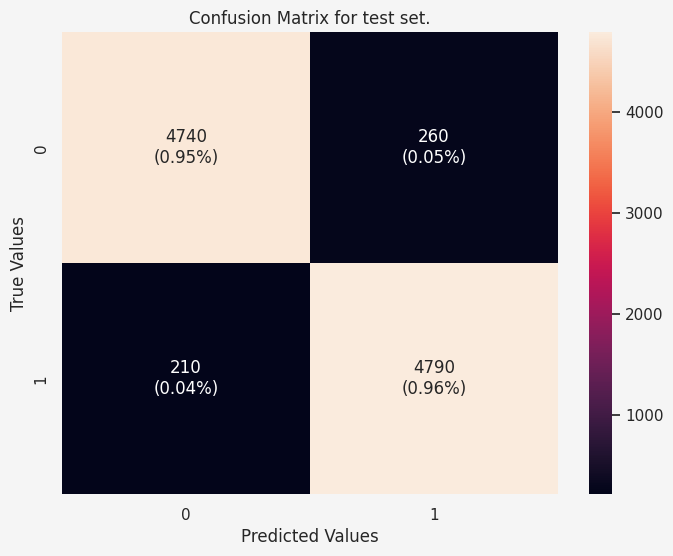

test [[4740  260]
 [ 210 4790]]
{'model_name': 'SVM', 'train_acc': 0.9761, 'test_acc': 0.953, 'train_recall': 0.9856, 'test_recall': 0.958, 'train_precision': 0.9672227674190382, 'test_precision': 0.9485148514851485, 'train_f1': 0.9763249133234273, 'test_f1': 0.9532338308457711}
24.39238739013672


In [23]:
#train SVM classifier
clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_X, train_y)

#Using above defined function to get accuracy, recall and precision on train and test set
test_predictions, results = get_metrics_score(clf_svm,train_X, train_y,\
                  test_X, test_y , model_name="SVM")
ConfusionMatrix(test_y, clf_svm.predict(test_X), set1="test")
print(results)

### 2. Decion Trees Model

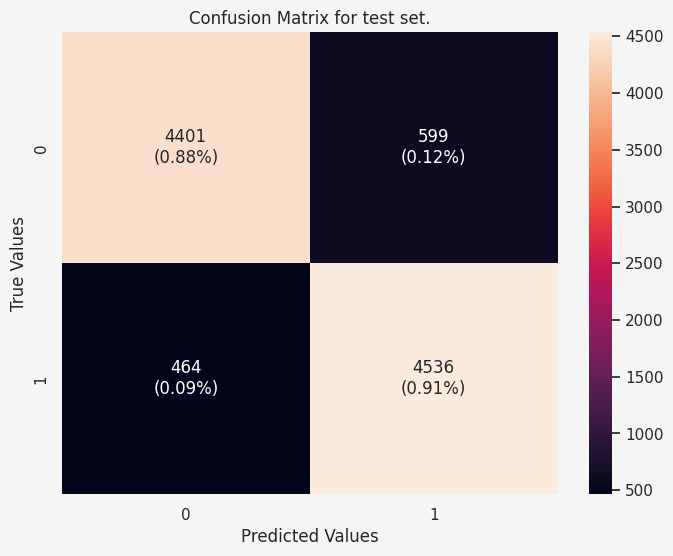

test [[4401  599]
 [ 464 4536]]
{'model_name': 'Decision Trees', 'train_acc': 0.9857, 'test_acc': 0.8937, 'train_recall': 1.0, 'test_recall': 0.9072, 'train_precision': 0.9721952167995334, 'test_precision': 0.8833495618305744, 'train_f1': 0.9859016070196195, 'test_f1': 0.8951159348791317}


In [24]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier()
clf_dec.fit(train_X, train_y)

#Using above defined function to get accuracy, recall and precision on train and test set
test_predictions, results = get_metrics_score(clf_dec, train_X, train_y,\
                  test_X, test_y , model_name="Decision Trees")
ConfusionMatrix(test_y, clf_dec.predict(test_X), set1="test")
print(results)

### 3. Naive Bayes

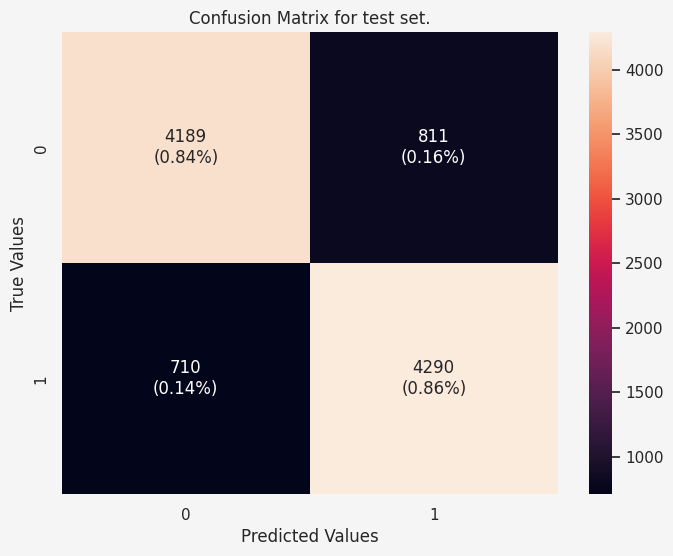

test [[4189  811]
 [ 710 4290]]
{'model_name': 'Naive Bayes', 'train_acc': 0.9387, 'test_acc': 0.8479, 'train_recall': 1.0, 'test_recall': 0.858, 'train_precision': 0.8907892392659896, 'test_precision': 0.8410115663595373, 'train_f1': 0.9422406482615661, 'test_f1': 0.8494208494208494}


In [25]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB()
clf_nb.fit(train_X.toarray(), train_y)

#Using above defined function to get accuracy, recall and precision on train and test set
test_predictions, results = get_metrics_score(clf_nb, train_X.toarray(), train_y,\
                  test_X.toarray(), test_y , model_name="Naive Bayes")
ConfusionMatrix(test_y, clf_nb.predict(test_X.toarray()), set1="test")
print(results)

### 4. Logistic Regression

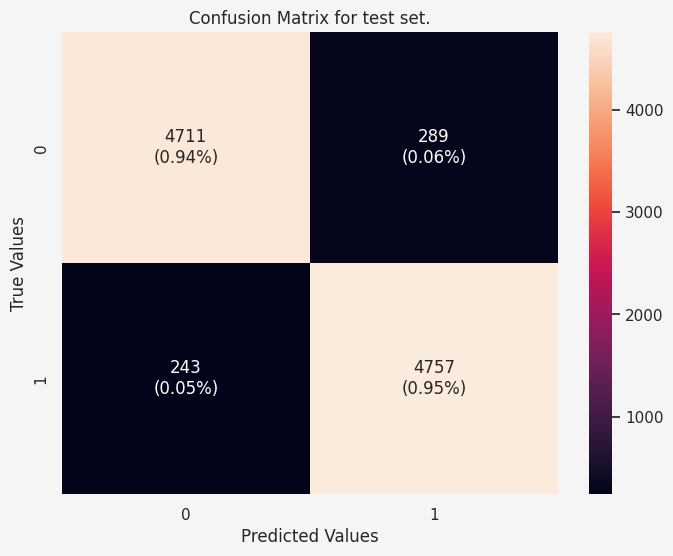

test [[4711  289]
 [ 243 4757]]
{'model_name': 'Logistic Regression', 'train_acc': 0.9623, 'test_acc': 0.9468, 'train_recall': 0.9692, 'test_recall': 0.9514, 'train_precision': 0.9560071019925035, 'test_precision': 0.942726912405866, 'train_f1': 0.9625583474029198, 'test_f1': 0.9470435994425642}


In [26]:
clf_log = LogisticRegression()
clf_log.fit(train_X, train_y)

#Using above defined function to get accuracy, recall and precision on train and test set
test_predictions, results = get_metrics_score(clf_log, train_X.toarray(), train_y,\
                  test_X.toarray(), test_y , model_name="Logistic Regression")
ConfusionMatrix(test_y, clf_log.predict(test_X.toarray()), set1="test")
print(results)

### 5. Ensemble Random Forest

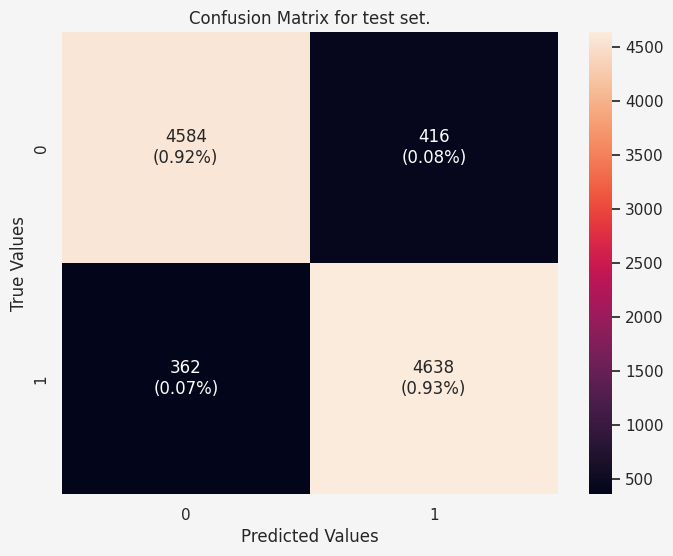

test [[4584  416]
 [ 362 4638]]
{'model_name': 'Random Forest', 'train_acc': 0.9857, 'test_acc': 0.9222, 'train_recall': 1.0, 'test_recall': 0.9276, 'train_precision': 0.9721952167995334, 'test_precision': 0.9176889592402058, 'train_f1': 0.9859016070196195, 'test_f1': 0.9226178635369008}


In [27]:
clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(train_X, train_y)

#Using above defined function to get accuracy, recall and precision on train and test set
test_predictions, results = get_metrics_score(clf_rf, train_X.toarray(), train_y,\
                  test_X.toarray(), test_y, model_name="Random Forest")
ConfusionMatrix(test_y, clf_rf.predict(test_X.toarray()), set1="test")
print(results)

### 6. Gradient Boost

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

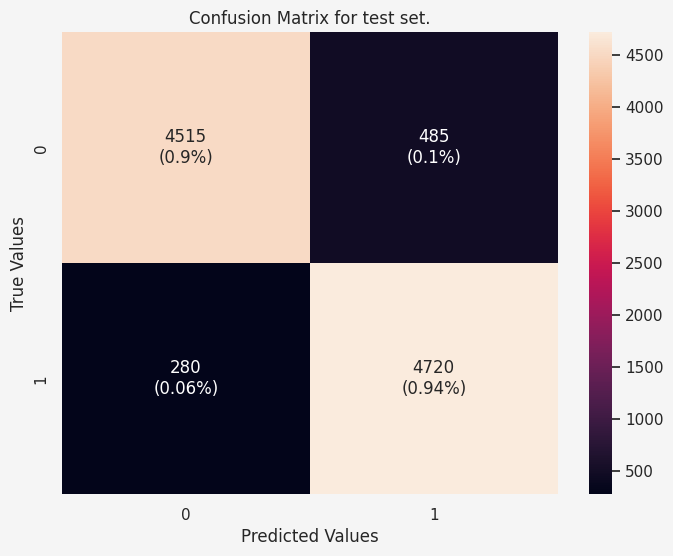

test [[4515  485]
 [ 280 4720]]
{'model_name': 'Gradient Boost', 'train_acc': 0.9456, 'test_acc': 0.9235, 'train_recall': 0.9658, 'test_recall': 0.944, 'train_precision': 0.9282968089196463, 'test_precision': 0.9068203650336215, 'train_f1': 0.9466771221329152, 'test_f1': 0.9250367466927976}


In [29]:
clf_gradient_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(train_X, train_y)

#Using above defined function to get accuracy, recall and precision on train and test set
test_predictions, results = get_metrics_score(clf_gradient_boost, train_X.toarray(), train_y,\
                  test_X.toarray(), test_y, model_name="Gradient Boost")
ConfusionMatrix(test_y, clf_gradient_boost.predict(test_X.toarray()), set1="test")
print(results)

In [30]:
results = pd.DataFrame(model_results)
results

,model_name,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1
0,SVM,0.9761,0.9530,0.9856,0.9580,0.967223,0.948515,0.976325,0.953234
1,Decision Trees,0.9857,0.8937,1.0000,0.9072,0.972195,0.883350,0.985902,0.895116
2,Naive Bayes,0.9387,0.8479,1.0000,0.8580,0.890789,0.841012,0.942241,0.849421
3,Logistic Regression,0.9623,0.9468,0.9692,0.9514,0.956007,0.942727,0.962558,0.947044
4,Random Forest,0.9857,0.9222,1.0000,0.9276,0.972195,0.917689,0.985902,0.922618
5,Gradient Boost,0.9456,0.9235,0.9658,0.9440,0.928297,0.906820,0.946677,0.925037


In [31]:
def plot_barplots(df, x, y, title, save_as):
    plt.figure(figsize=(11,5))
    # Create the bar plot
    ax = sns.barplot(data=results, y=y, x=x)

    plt.title(title)
    # Add labels to each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.savefig(f'./plots/{save_as}.png')
    plt.show()

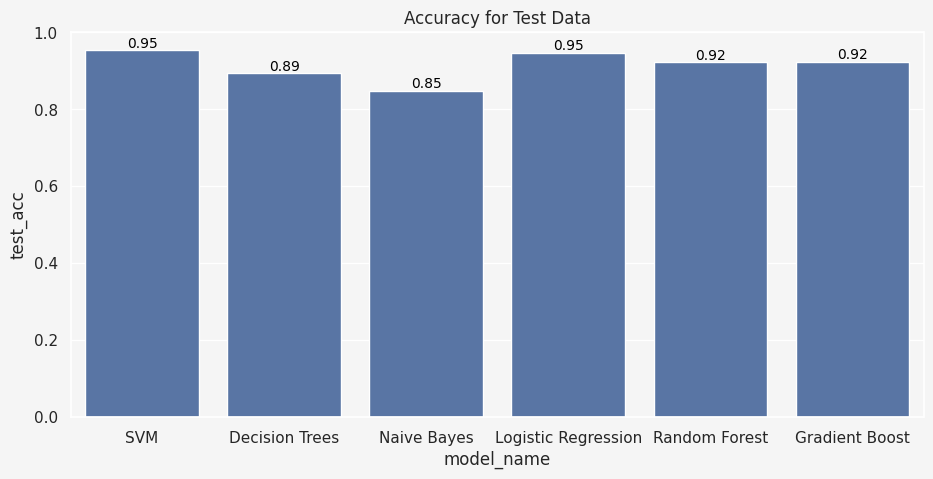

In [32]:
plot_barplots(df=results, x="model_name", y="test_acc", title="Accuracy for Test Data",
             save_as="test_acc")

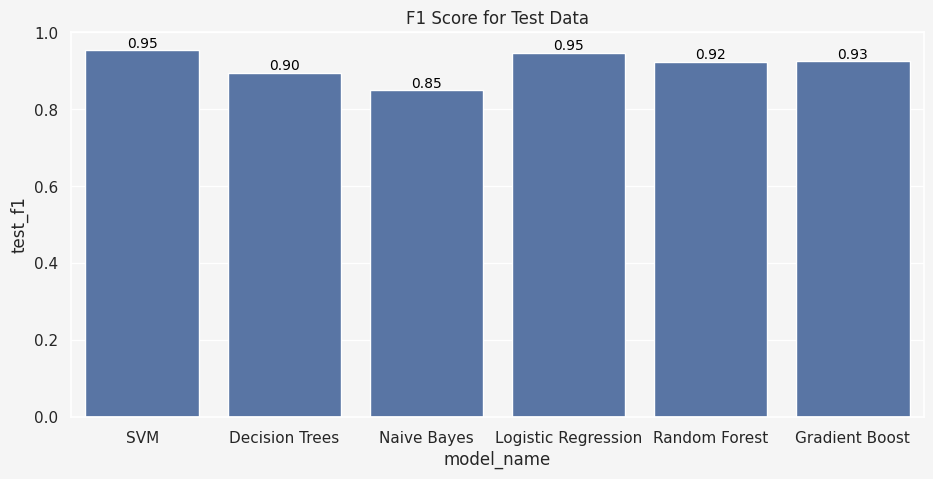

In [33]:
plot_barplots(df=results, x="model_name", y="test_f1", title="F1 Score for Test Data",
             save_as="test_f1")

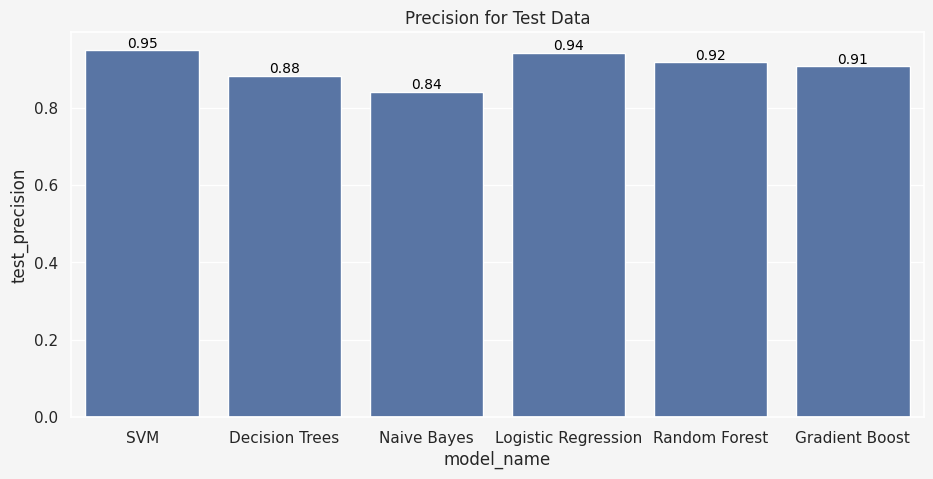

In [34]:
plot_barplots(df=results, x="model_name", y="test_precision", title="Precision for Test Data",
             save_as="test_precision")

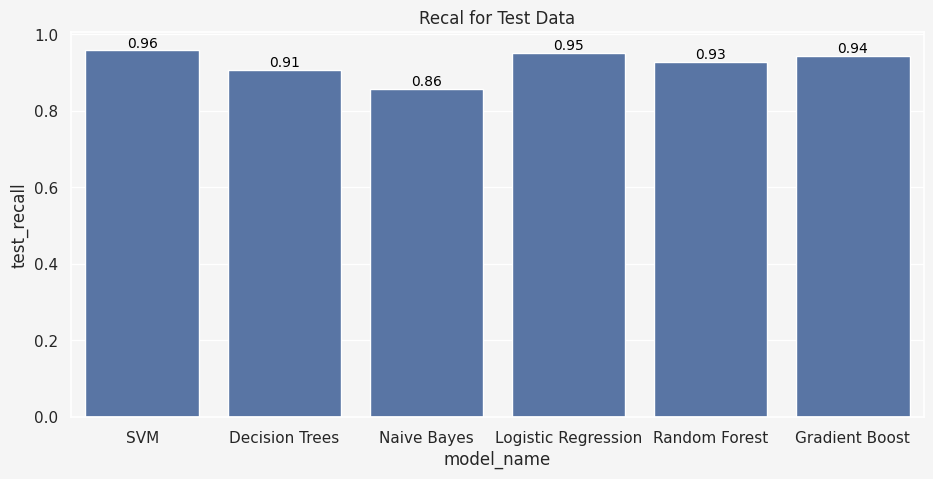

In [35]:
plot_barplots(df=results, x="model_name", y="test_recall", title="Recal for Test Data",
             save_as="test_recall")

In [36]:
results

,model_name,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1
0,SVM,0.9761,0.9530,0.9856,0.9580,0.967223,0.948515,0.976325,0.953234
1,Decision Trees,0.9857,0.8937,1.0000,0.9072,0.972195,0.883350,0.985902,0.895116
2,Naive Bayes,0.9387,0.8479,1.0000,0.8580,0.890789,0.841012,0.942241,0.849421
3,Logistic Regression,0.9623,0.9468,0.9692,0.9514,0.956007,0.942727,0.962558,0.947044
4,Random Forest,0.9857,0.9222,1.0000,0.9276,0.972195,0.917689,0.985902,0.922618
5,Gradient Boost,0.9456,0.9235,0.9658,0.9440,0.928297,0.906820,0.946677,0.925037


## Saving Trained Model

In [37]:
import pickle
# Save SVM model
with open('./models/review_classifier.pkl', 'wb') as f:
    pickle.dump(clf_svm, f)

In [38]:
# Loading the model
import pickle
with open('./models/review_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

## Missed cases

In [39]:
# Using the loaded model
predictions = {"Review": test_x_data,
            "True": [labels[i] for i in test_y],
            "Predicted": [labels[i] for i in loaded_clf.predict(test_X)]}

In [40]:
df_predictions = pd.DataFrame(predictions)
missed = df_predictions[df_predictions["True"]!=df_predictions["Predicted"]]
missed.head()

,Review,True,Predicted
15,Got money returned several times when the exch...,Negative,Positive
26,Useful,Negative,Positive
57,It's a shame that they spoiled such a great se...,Negative,Positive
60,Useful,Negative,Positive
80,Useful,Negative,Positive


## You Can Test your Case Here

In [52]:
a = vectorizer.transform(['Very fun', "Really bad service!!", 'Slow', "Expensive", 
                          "Transfer is quick", "Cheaper than high-street banks"])
print("Prediction",[labels[i] for i in clf_svm.predict(a)])

Prediction ['Positive', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive']
